In [837]:
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from matplotlib.patches import Patch
import pandas as pd
from typing import Callable
from copy import deepcopy


pd.options.display.max_columns = 21
pd.options.display.float_format = '{:.2f}'.format

In [838]:
Card = int
Hand = tuple[int, int, int, int, int, int, int, int, int, int, int, int, int]
Action = int
Policy = Callable[[Hand, Hand], Action]
PlayerPolicy = Callable[[Hand, Card], Action]
Deck = np.ndarray[int]
DeckProb = list[float]

ACE: Card = 1
TWO: Card = 2
THREE: Card = 3
FOUR: Card = 4
FIVE: Card = 5
SIX: Card = 6
SEVEN: Card = 7
EIGHT: Card = 8
NINE: Card = 9
TEN: Card = 10
JACK: Card = 10
QUEEN: Card = 10
KING: Card = 10

card_values: list[Card] = [ACE, TWO, THREE, FOUR, FIVE, SIX, SEVEN, EIGHT, NINE, TEN, JACK, QUEEN, KING]
num_cards: int = len(card_values)
cards: list[int] = list(range(num_cards))

max_card_value: int = max(card_values)
max_score: int = 21

In [839]:
HIT: Action = 0
STAND: Action = 1
DOUBLE: Action = 2
SPLIT: Action = 3
SURRENDER: Action = 4

actions_str: dict[Action, str] = {
    HIT: 'Hit',
	STAND: 'Stand',
	DOUBLE: 'Double',
	SPLIT: 'Split',
	SURRENDER: 'Surrender',
}

actions_color: dict[Action, str] = {
    HIT: 'lightgreen',
	STAND: 'indianred',
	DOUBLE: 'lightblue',
	SPLIT: 'khaki',
	SURRENDER: 'orange',
	np.nan: 'white',
}

In [840]:
def probaDraw(card: Card, deckProb: DeckProb) -> float:
	"""
	Probability of hitting a given card
	"""
	return deckProb[card]

In [841]:
def countScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Score of some cards
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""
	score = 0
	score += ace * ACE
	score += two * TWO
	score += three * THREE
	score += four * FOUR
	score += five * FIVE
	score += six * SIX
	score += seven * SEVEN
	score += eight * EIGHT
	score += nine * NINE
	score += ten * TEN
	score += jack * JACK
	score += queen * QUEEN
	score += king * KING
	while score <= max_score -10 and ace > 0:
		score += 10
		ace -= 1
	return score

def minScore(ace=0, two=0, three=0, four=0, five=0, six=0, seven=0, eight=0, nine=0, ten=0, jack=0, queen=0, king=0) -> int:
	"""
	Minimum possible score of some cards
	Each ace is counted as 1
	"""
	score = 0
	score += ace * ACE
	score += two * TWO
	score += three * THREE
	score += four * FOUR
	score += five * FIVE
	score += six * SIX
	score += seven * SEVEN
	score += eight * EIGHT
	score += nine * NINE
	score += ten * TEN
	score += jack * JACK
	score += queen * QUEEN
	score += king * KING
	return score

def handScore(hand: Hand) -> int:
	"""
	Score of a hand
	Each ace is counted as 11 if the total score is less than or equal to 21, otherwise it is counted as 1
	"""	
	return countScore(*hand)

def minHandScore(hand: Hand) -> int:
	"""
	Minimum possible score of a hand
	Each ace is counted as 1
	"""
	return minScore(*hand)

def haveAce11(hand: Hand) -> bool:
	"""
	Do we have an ace counted as 11 in a hand
	"""
	return minHandScore(hand) != handScore(hand)

In [842]:
valid_hands_to_index: dict[Hand, int] = {}
idx = 0
for ace in range(0, max_score+1):
	score = minScore(ace)
	for two in range(0, (max_score-score) // TWO +1):
		score = minScore(ace, two)
		for three in range(0, (max_score-score) // THREE +1):
			score = minScore(ace, two, three)
			for four in range(0, (max_score-score) // FOUR +1):
				score = minScore(ace, two, three, four)
				for five in range(0, (max_score-score) // FIVE +1):
					score = minScore(ace, two, three, four, five)
					for six in range(0, (max_score-score) // SIX +1):
						score = minScore(ace, two, three, four, five, six)
						for seven in range(0, (max_score-score) // SEVEN +1):
							score = minScore(ace, two, three, four, five, six, seven)
							for eight in range(0, (max_score-score) // EIGHT +1):
								score = minScore(ace, two, three, four, five, six, seven, eight)
								for nine in range(0, (max_score-score) // NINE +1):
									score = minScore(ace, two, three, four, five, six, seven, eight, nine)
									for ten in range(0, (max_score-score) // TEN +1):
										score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten)
										for jack in range(0, (max_score-score) // JACK +1):
											score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack)
											for queen in range(0, (max_score-score) // QUEEN +1):
												score = minScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen)
												for king in range(0, (max_score-score) // KING +1):
													score = countScore(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)
													if score <= max_score:
														valid_hands_to_index[(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)] = idx
														idx += 1

num_hands = len(valid_hands_to_index)
index_to_valid_hands: list[Hand] = [None] * num_hands
for hand, idx in valid_hands_to_index.items():
	index_to_valid_hands[idx] = hand

print(f"Number of valid hands: {num_hands}")

Number of valid hands: 3677


In [843]:
def createHand(*args: Card) -> Hand:
	"""
	Create a hand from a list of cards
	Note that 0 correspond to an ace, 1 to a two, 2 to a three, ..., 9 to a ten, 10 to a jack, 11 to a queen and 12 to a king
	"""
	hand = [0] * num_cards
	for card in args:
		hand[card] += 1
	return tuple(hand)

def addCard(hand: Hand, card: Card) -> Hand:
	"""
	Add a card to a hand
	"""
	hand = list(hand)
	hand[card] += 1
	return tuple(hand)

In [844]:
def validHandsFromDeck(deck: Card) -> list[int]:
	"""
	Hand after drawing a card
	"""
	valid_idx = []
	for ace in range(0, min(deck[0], max_score) +1):
		ace_score = minScore(ace=ace)
		for two in range(0, min(deck[1], (max_score-ace_score) // TWO) +1):
			two_score = minScore(two=two) + ace_score
			for three in range(0, min(deck[2], (max_score-two_score) // THREE) +1):
				three_score = minScore(three=three) + two_score
				for four in range(0, min(deck[3], (max_score-three_score) // FOUR) +1):
					four_score = minScore(four=four) + three_score
					for five in range(0, min(deck[4], (max_score-four_score) // FIVE) +1):
						five_score = minScore(five=five) + four_score
						for six in range(0, min(deck[5], (max_score-five_score) // SIX) +1):
							six_score = minScore(six=six) + five_score
							for seven in range(0, min(deck[6], (max_score-six_score) // SEVEN) +1):
								seven_score = minScore(seven=seven) + six_score
								for eight in range(0, min(deck[7], (max_score-seven_score) // EIGHT) +1):
									eight_score = minScore(eight=eight) + seven_score
									for nine in range(0, min(deck[8], (max_score-eight_score) // NINE) +1):
										nine_score = minScore(nine=nine) + eight_score
										for ten in range(0, min(deck[9], (max_score-nine_score) // TEN) +1):
											ten_score = minScore(ten=ten) + nine_score
											for jack in range(0, min(deck[10], (max_score-ten_score) // JACK) +1):
												jack_score = minScore(jack=jack) + ten_score
												for queen in range(0, min(deck[11], (max_score-jack_score) // QUEEN) +1):
													queen_score = minScore(queen=queen) + jack_score
													for king in range(0, min(deck[12], (max_score-queen_score) // KING) +1):
														king_score = minScore(king=king) + queen_score
														if king_score <= max_score:
															valid_idx.append(valid_hands_to_index[(ace, two, three, four, five, six, seven, eight, nine, ten, jack, queen, king)])
	return valid_idx

In [845]:
def checkBlackjack(hand: Hand, score: int=None) -> bool:
	"""
	Check if a hand is a blackjack
	Score is the score of the hand if it is already computed
	"""
	score = score or handScore(hand)
	return handScore(hand) == max_score and sum(hand) == 2

def couldBlackJack(hand: Hand) -> bool:
	"""
	Check if a hand could be a blackjack
	"""
	match sum(hand):
		case 0:
			return True
		case 1:
			return hand[0] == 1 or hand[9] == 1 or hand[10] == 1 or hand[11] == 1 or hand[12] == 1
		case 2:
			return handScore(hand) == max_score
		case _:
			return False

def handComparisonDealerPOV(dealer_hand: Hand, player_hand: Hand) -> float:
	"""
	Compare two valid hands
	Return 1 if the dealer wins, 0 if it is a draw and -1 if the player wins
	Check if there is a blackjack for the dealer and the player
	"""
	sd = handScore(dealer_hand)
	sp = handScore(player_hand)
	dealer_blackjack = checkBlackjack(dealer_hand, sd)
	player_blackjack = checkBlackjack(player_hand, sp)
	assert sd <= max_score and sp <= max_score
	if dealer_blackjack and player_blackjack:
		return 0
	elif dealer_blackjack:
		return 1
	elif player_blackjack:
		return -1.5
	elif sd > sp:
		return 1
	elif sd < sp:
		return -1
	else:
		return 0
 

In [846]:
def updateDeckProb(deck: Deck) -> DeckProb:
	"""
	Update the probability of drawing a card
	"""
	if sum(deck) <= 0:
		return [0] * num_cards
	deckProb: DeckProb = [0] * num_cards
	for card in cards:
		deckProb[card] = deck[card] / sum(deck)
	return deckProb

In [847]:
def probaHit(hand: Hand, deck: Deck) -> float:
	"""
	Probability of hitting and not bursting
	"""
	deckProb = updateDeckProb(deck)
	return sum(probaDraw(card, deckProb) for card in cards if addCard(hand, card) in valid_hands_to_index and deck[card] > 0)

def probaHitList(hand: Hand, deck: Deck) -> list[Hand, float]:
	"""
	Compute the score and the probability of hitting for each card that do not burst the score
	"""
	deckProb = updateDeckProb(deck)
	return [(addCard(hand, card), probaDraw(card, deckProb)) for card in cards if addCard(hand, card) in valid_hands_to_index and deck[card] > 0]

In [848]:
def probaBurst(hand: Hand, deck: Deck) -> float:
	"""
	Probability of bursting
	"""
	return 1 - probaHit(hand, deck)

def probaBurstList(hand: Hand, deck: Deck) -> list[Hand, float]:
	"""
	Compute the score and the probability of bursting for each card that burst the score
	"""
	deckProb = updateDeckProb(deck)
	return [(addCard(hand, card), probaDraw(card, deckProb)) for card in cards if handScore(hand) + card_values[card] > max_score and deck[card] > 0]

In [849]:
def getDealerGainMatrix(policy: Policy, hand_player: Hand, deck: Deck) -> np.ndarray:
	"""
	Compute the gain matrix for the dealer optimal policy
	It consider that only 2 actions are possible: hit or stand
	"""
	gainMatrix = np.zeros(num_hands)
	for hand_dealer_idx in validHandsFromDeck(deck)[::-1]:
		hand_dealer = index_to_valid_hands[hand_dealer_idx]
		new_deck = deck.copy()
		new_deck -= np.array(hand_dealer)
		if (new_deck < 0).any():
			gainMatrix[hand_dealer_idx] = np.nan
		
		action = policy(hand_player, hand_dealer)

		if action == HIT:
			hit_score = 0
			for new_hand, proba in probaHitList(hand_dealer, new_deck):
				hit_score += proba * gainMatrix[valid_hands_to_index[new_hand]]
			burst_score = probaBurst(hand_dealer, new_deck)
			gainMatrix[hand_dealer_idx] = hit_score - burst_score
			#print(f"Hit score: {hit_score}, Burst score: {burst_score} HandScore: {handScore(hand_dealer)}")
			# print(f"Hit score: {hit_score}, Burst score: {burst_score} gainScore: {gainMatrix[hand_dealer_idx]} HandScore: {handScore(hand_dealer)}")

   
		elif action == STAND:  
			gainMatrix[hand_dealer_idx] = handComparisonDealerPOV(hand_dealer, hand_player)
			#print(f"Gain when stand: {gainMatrix[hand_dealer_idx]}")
		#print(f"gain: {gainMatrix[hand_dealer_idx]}")
		#if np.sum(hand_dealer) == 1:
		#	assert action == HIT
		#	hit_score = 0
		#	for new_hand, proba in probaHitList(hand_dealer, new_deck):
		#		#print(f"Next hands gain: {gainMatrix[valid_hands_to_index[new_hand]]} idx: {valid_hands_to_index[new_hand]} self idx {hand_dealer_idx}")
		#		assert gainMatrix[valid_hands_to_index[new_hand]] != -10, "Case not filled"
		#		hit_score += proba * gainMatrix[valid_hands_to_index[new_hand]]
		#	burst_score = probaBurst(hand_dealer, new_deck)
			#print(f"One Card Hit score: {hit_score}, Burst score: {burst_score} HandScore: {handScore(hand_dealer)}")
		#elif np.sum(hand_dealer) == 2:
			#print(f"Hand dealer 2 cards: {handScore(hand_dealer)}, player_score: {handScore(hand_player)}, deck: {new_deck}")
			#print(f"gain: {gainMatrix[hand_dealer_idx]}")
		#	if action == HIT:
		#		hit_score = 0
		#		for new_hand, proba in probaHitList(hand_dealer, new_deck):
		#			#print(f"Next hands gain: {gainMatrix[valid_hands_to_index[new_hand]]} idx: {valid_hands_to_index[new_hand]} self idx {hand_dealer_idx}")
		#			assert gainMatrix[valid_hands_to_index[new_hand]] != -10, "Case not filled"
		#			hit_score += proba * gainMatrix[valid_hands_to_index[new_hand]]
		#		burst_score = probaBurst(hand_dealer, new_deck)
				#print(f"Hit score: {hit_score}, Burst score: {burst_score} HandScore: {handScore(hand_dealer)}")
		#print(f"gain: {gainMatrix[hand_dealer_idx]}")
	#for card in cards:
	#	print(f"For card: {card} gain: {gainMatrix[valid_hands_to_index[createHand(card)]]}")
	return gainMatrix

In [850]:
def getGainMatrixPlayerOptimalPolicy(dealer_policy, deck: Deck) -> np.ndarray:
	"""
	Compute the gain matrix for the player optimal policy
	It consider that 2 actions are possible: hit or stand
	The player policy is also computed and returned
	"""
	gainMatrix = np.zeros((num_hands, 13))
	policyMatrix = np.zeros((num_hands, 13))
	dealerGainDict = {}
	for hand_player_idx in range(num_hands-1, -1, -1):
		hand_player = index_to_valid_hands[hand_player_idx]
		deck_hand_player = deck.copy()
		for card_dealer in cards:
			hand_dealer = createHand(card_dealer)
			hand_dealer_idx = valid_hands_to_index[hand_dealer]
			new_deck = deck.copy()
			new_deck -= np.array(hand_player)
			new_deck_no_dealer = new_deck.copy()
			new_deck[card_dealer] -= 1
			if (new_deck < 0).any():
				gainMatrix[hand_player_idx, card_dealer] = np.nan
				continue
			hit_score = 0
			for new_hand, proba in probaHitList(hand_player, new_deck):
				hit_score += proba * gainMatrix[valid_hands_to_index[new_hand], card_dealer]
			hit_score -= probaBurst(hand_player, new_deck)
			
			if hand_player in dealerGainDict:
				stand_score = -(dealerGainDict[hand_player])[hand_dealer_idx]
			else:
				dealerGainDict[hand_player] = getDealerGainMatrix(dealer_policy, hand_player, new_deck_no_dealer)
				# print(f"Computed for hand: {hand_player} {hand_player_idx} card: {card_dealer}")
				stand_score = -(dealerGainDict[hand_player])[hand_dealer_idx]
				#if stand_score != 0:
				#	print(f"Stand score: {stand_score} for hand: {hand_player} {hand_player_idx} card: {card_dealer}")
			# print(hit_score, stand_score)
			gainMatrix[hand_player_idx, card_dealer] = max(hit_score, stand_score)
			policyMatrix[hand_player_idx, card_dealer] = HIT if hit_score >= stand_score else STAND
	return gainMatrix, policyMatrix

In [851]:
def standOn17Hard(player_hand: hand, dealer_hand: hand) -> Action:
	"""
	Dealer stand on 17 hard
	"""
	return STAND if handScore(dealer_hand) >= 17 else HIT

In [852]:
def standOn17Soft(player_hand: hand, dealer_hand: hand) -> Action:
	"""
	Dealer stand on 17 soft
	"""
	return STAND if minHandScore(dealer_hand) >= 17 else HIT

In [ ]:
deck = [4] * num_cards
playerGainMatrix, playerPolicyMatrix = getGainMatrixPlayerOptimalPolicy(standOn17Hard, deck)

In [ ]:
def plot_single_policy_matrix(policy_matrix, title=None, ax=None, cmap=None, norm=None, plot_legend=True, xlegend=None, ylegend=None, xcard=False, ycard=False,  xlegend_dec=0, ylegend_dec=0):
    xlabel = np.arange(1 + xlegend_dec, policy_matrix.shape[1] + 1 + xlegend_dec, 1) if not xcard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"][xlegend_dec:policy_matrix.shape[1] + xlegend_dec]
    ylabel = np.arange(1 + ylegend_dec, policy_matrix.shape[0] + 1 + ylegend_dec, 1) if not ycard else ["2", "3", "4", "5", "6", "7", "8", "9", "10", "V", "D", "R", "A"][ylegend_dec:policy_matrix.shape[0] + ylegend_dec]
    xlegend = xlegend if xlegend is not None else "Dealer Card Value"
    ylegend = ylegend if ylegend is not None else "Player Score"
    unique_values = sorted(set(val for val in np.unique(policy_matrix)))
    unique_values = [val for val in unique_values if not np.isnan(val)]
    # Check if has nan values
    # print(np.isnan(policy_matrix).any())
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 10))
    else:
        fig = ax.figure 
    
        unique_values = sorted(set(val for val in np.unique(policy_matrix) if not np.isnan(val)))

    # Création d'un cmap basé sur les couleurs spécifiées
    cmap = cmap if cmap is not None else mcolors.ListedColormap([actions_color[action] for action in unique_values])    
    norm = norm if norm is not None else mcolors.BoundaryNorm(boundaries=np.linspace(min(unique_values) - 0.5, max(unique_values) + 0.5, len(unique_values) + 1), ncolors=len(unique_values))
    im = ax.imshow(policy_matrix, cmap=cmap, norm=norm, aspect="auto", origin="lower")
    if title:
        ax.set_title(title, fontsize=14, pad=20)
    
    ax.set_xticks(np.arange(0, policy_matrix.shape[1]))
    ax.set_yticks(np.arange(0, policy_matrix.shape[0]))
    ax.set_xticklabels(xlabel)
    ax.set_yticklabels(ylabel)
    ax.set_xlabel(xlegend, fontsize=12, labelpad=15)
    ax.set_ylabel(ylegend, fontsize=12, labelpad=15)
    ax.set_xticks(np.arange(-.5, policy_matrix.shape[1], 1), minor=True)
    ax.set_yticks(np.arange(-.5, policy_matrix.shape[0], 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
    ax.tick_params(which='minor', bottom=False, left=False)
    
    if plot_legend:
        actions_str = [f"Action {int(val)}" for val in unique_values]
        legend_patches = [Patch(color=cmap(norm(val)), label=actions_str[int(val)]) for val in unique_values]
        ax.legend(handles=legend_patches, loc="upper center", ncol=len(unique_values), 
                  frameon=False, fontsize=12, handlelength=2, handletextpad=1, bbox_to_anchor=(0.5, 1.1))
        fig.subplots_adjust(top=0.85)
    
    return im


def plot_policy_matrices(policyMatrices, options=None):
    options = options or {}
    num_matrices = len(policyMatrices)
    fig, axes = plt.subplots(1, num_matrices, figsize=(5 * num_matrices, 10))
    if num_matrices == 1:
        axes = [axes]
    all_unique_values = sorted(set(val for matrix in policyMatrices for val in np.unique(matrix) if not np.isnan(val)))

    # Création d'un cmap basé sur les couleurs spécifiées
    cmap = mcolors.ListedColormap([actions_color[action] for action in all_unique_values])
    norm = mcolors.BoundaryNorm(boundaries=np.arange(len(all_unique_values) + 1) - 0.5, ncolors=len(all_unique_values))
    
    for i, (policy, options) in enumerate(zip(policyMatrices, options)):
        plot_single_policy_matrix(policy, ax=axes[i], cmap=cmap, norm=norm, plot_legend=False, **options)
    
    legend_patches = [Patch(color=cmap(i / max(len(all_unique_values) - 1, 1)), label=actions_str[int(val)])
                      for i, val in enumerate(all_unique_values)]
    fig.legend(handles=legend_patches, loc="upper center", ncol=len(all_unique_values),
               frameon=False, fontsize=14, handlelength=2, handletextpad=1)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [860]:
def plot_policy_results(policyMatrix):
	
	policyMatrix = np.array(policyMatrix)
	
	policyMismatch = np.full((17, 13), np.nan)
	for card in card_values[1:]:
		for card_dealer in cards:
			hand_player1 = createHand(card-1, card+1)
			hand_player2 = createHand(card, card - 1)
			hand_player_idx1 = valid_hands_to_index[hand_player1]
			hand_player_idx2 = valid_hands_to_index[hand_player2]
			policyMismatch[handScore(hand_player1)-5, card_dealer-1] = policyMatrix[hand_player_idx1, card_dealer]
			policyMismatch[handScore(hand_player2)-5, card_dealer-1] = policyMatrix[hand_player_idx2, card_dealer]
	policyMismatch[21-5, :] = policyMatrix[valid_hands_to_index[createHand(7, 6, 5)], :]
	optionsMismatch = {
		"title": "Mismatched cards",
		"ylegend": "Player Score",
		"ylegend_dec": 4,
		"xcard": True,
    }
   
	policyPairs = np.full((13, 13), np.nan)
	for card_1 in cards:
		for card_dealer in cards:
			hand_player = createHand(card_1, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyPairs[card_1, card_dealer-1] = policyMatrix[hand_player_idx, card_dealer]
	policyPairs = np.roll(policyPairs, -1, axis=0)
	optionsPairs = {
		"title": "Pairs",
		"ylegend": "Card",
		"ycard": True,
		"xcard": True,
	}

	policyAs = np.full((12, 13), np.nan)
	for card_1 in cards[1:]:
		for card_dealer in cards:
			hand_player = createHand(0, card_1)
			hand_player_idx = valid_hands_to_index[hand_player]
			policyAs[card_1-1, card_dealer-1] = policyMatrix[hand_player_idx, card_dealer]
	optionsAs = {
		"title": "Ace",
		"ylegend": "Second Card",
		"ylegend_dec": 1,
		"ycard": True,
		"xcard": True,
	}
   
	plot_policy_matrices([policyMismatch, policyPairs, policyAs], [optionsMismatch, optionsPairs, optionsAs])

False
False
False


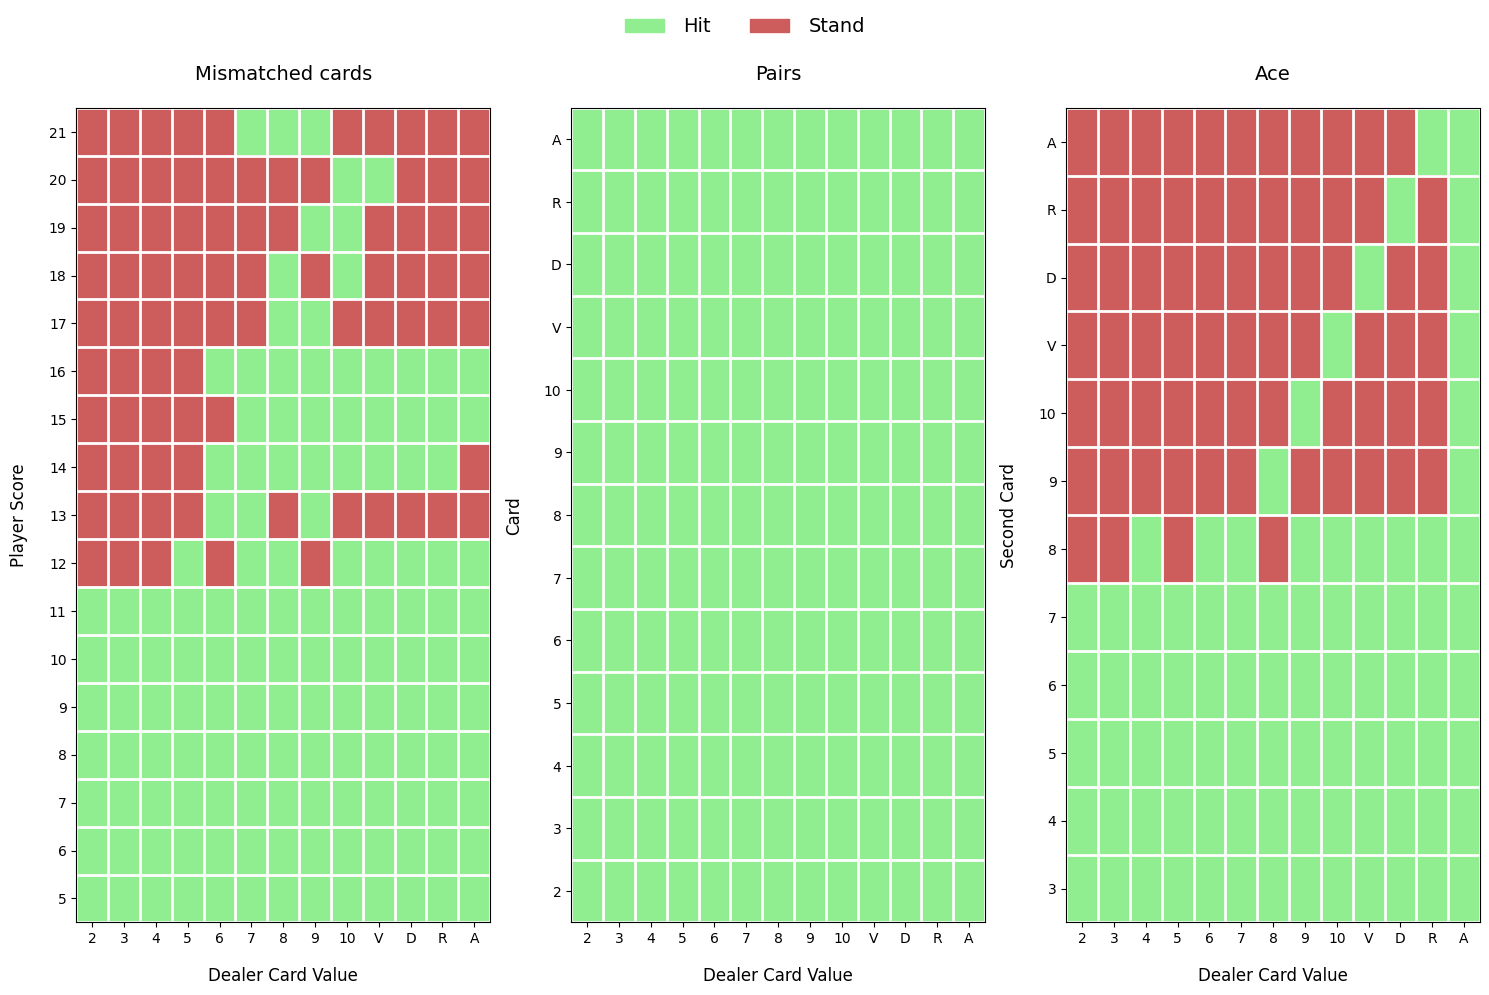

In [861]:
plot_policy_results(playerPolicyMatrix)

In [862]:
def computePlayerGlobalGain(playerGainMatrix: np.ndarray, deck: Deck) -> float:
	"""
	Compute the global gain for the player
	"""
	gain = 0
	deck0 = deck.copy()
	for card1_player in card_values:
		for card2_player in card_values:
			for card_dealer in cards:
				assert deck == deck0
				proba = probaDraw(card1_player, deckProb=updateDeckProb(deck))
				deck[card1_player] -= 1
				proba *= probaDraw(card2_player, deckProb=updateDeckProb(deck))
				deck[card2_player] -= 1
				proba *= probaDraw(card_dealer, deckProb=updateDeckProb(deck))
				gain += playerGainMatrix[valid_hands_to_index[createHand(card1_player, card2_player)], card_dealer] * proba
				deck[card1_player] += 1
				deck[card2_player] += 1
	return gain

In [863]:
print(f"Player global gain: {computePlayerGlobalGain(playerGainMatrix, deck)}")

Player global gain: nan
